# CBB Matchup Analyzer – Hello World

This notebook is a minimal “hello world” scaffold for a college basketball (CBB) matchup analyzer.

In this step we will:
- Verify the Python environment and core libraries
- Create a tiny synthetic game log dataset for a few teams
- Compute basic tempo (possessions) and efficiency (PPP)
- Visualize a simple relationship (tempo vs offensive efficiency)

This is just a scaffold; later notebooks will:
- Load real game data
- Build matchup projections
- Compare to sportsbook lines and flag anomalies

Python version: 3.10.12
NumPy version: 2.2.6
Pandas version: 2.3.3
Matplotlib version: 3.10.8


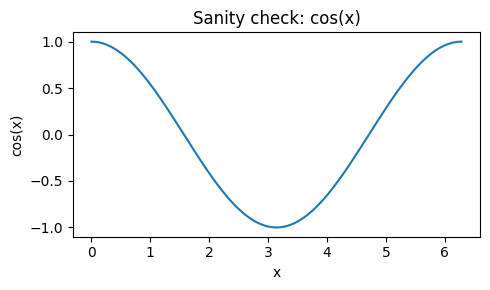

In [3]:
# Step 2: Environment check inside the notebook

import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

print("Python version:", sys.version.split()[0])
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)

# Quick smoke test plot
xs = np.linspace(0, 2 * np.pi, 200)
ys = np.cos(xs)

plt.figure(figsize=(5, 3))
plt.plot(xs, ys)
plt.title("Sanity check: cos(x)")
plt.xlabel("x")
plt.ylabel("cos(x)")
plt.tight_layout()
plt.show()

In [4]:
# Step 2: Tiny synthetic CBB game log

# We'll create a few fake games for two teams
data = [
    # date, team, opponent, pts_for, pts_against, fga, fta, orb, tov
    ("2025-12-01", "Team A", "Team B", 78, 72, 55, 20, 10, 12),
    ("2025-12-05", "Team A", "Team C", 82, 75, 58, 18, 9,  11),
    ("2025-12-08", "Team B", "Team A", 70, 80, 52, 22, 11, 14),
    ("2025-12-10", "Team B", "Team C", 65, 68, 50, 15, 8,  13),
]

columns = ["date", "team", "opponent", "pts_for", "pts_against", "fga", "fta", "orb", "tov"]

games = pd.DataFrame(data, columns=columns)
games["date"] = pd.to_datetime(games["date"])

games

,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov
0,2025-12-01,Team A,Team B,78,72,55,20,10,12
1,2025-12-05,Team A,Team C,82,75,58,18,9,11
2,2025-12-08,Team B,Team A,70,80,52,22,11,14
3,2025-12-10,Team B,Team C,65,68,50,15,8,13


In [5]:
# Step 2: Compute possessions, offensive PPP, defensive PPP

def estimate_possessions(row: pd.Series) -> float:
    """
    Classic estimate:
    Poss = FGA - ORB + TOV + 0.475 * FTA
    """
    return row["fga"] - row["orb"] + row["tov"] + 0.475 * row["fta"]

games["poss"] = games.apply(estimate_possessions, axis=1)
games["opp_poss"] = games["poss"]  # symmetric in this simple model

games["off_ppp"] = games["pts_for"] / games["poss"]
games["def_ppp"] = games["pts_against"] / games["opp_poss"]

games


,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov,poss,opp_poss,off_ppp,def_ppp
0,2025-12-01,Team A,Team B,78,72,55,20,10,12,66.500,66.500,1.172932,1.082707
1,2025-12-05,Team A,Team C,82,75,58,18,9,11,68.550,68.550,1.196207,1.094092
2,2025-12-08,Team B,Team A,70,80,52,22,11,14,65.450,65.450,1.069519,1.222307
3,2025-12-10,Team B,Team C,65,68,50,15,8,13,62.125,62.125,1.046278,1.094567


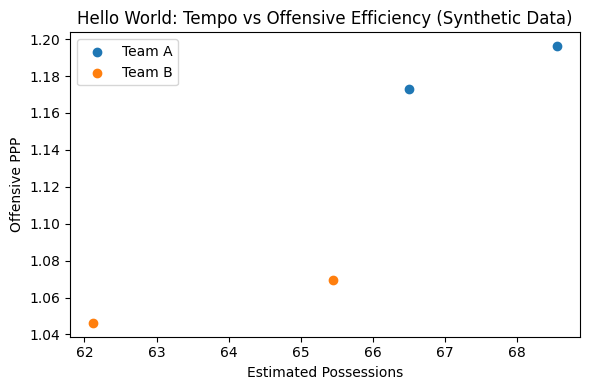

In [6]:
# Step 2: Simple visualization – tempo vs offensive efficiency

plt.figure(figsize=(6, 4))

for team in games["team"].unique():
    sub = games[games["team"] == team]
    plt.scatter(sub["poss"], sub["off_ppp"], label=team)

plt.xlabel("Estimated Possessions")
plt.ylabel("Offensive PPP")
plt.title("Hello World: Tempo vs Offensive Efficiency (Synthetic Data)")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

df = pd.read_csv("../data/cbb_games_sample.csv", parse_dates=["date"])

df


,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov,three_pa,three_pm
0,2025-01-01,Team A,Team B,78,72,55,20,10,12,25,8
1,2025-01-05,Team A,Team C,82,75,58,18,9,11,28,10
2,2025-01-08,Team B,Team A,70,80,52,22,11,14,22,6
3,2025-01-10,Team B,Team C,65,68,50,15,8,13,18,5


In [8]:
def estimate_possessions(row):
    return row.fga - row.orb + row.tov + 0.475 * row.fta

df["poss"] = df.apply(estimate_possessions, axis=1)
df["off_ppp"] = df["pts_for"] / df["poss"]
df["def_ppp"] = df["pts_against"] / df["poss"]

df


,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov,three_pa,three_pm,poss,off_ppp,def_ppp
0,2025-01-01,Team A,Team B,78,72,55,20,10,12,25,8,66.500,1.172932,1.082707
1,2025-01-05,Team A,Team C,82,75,58,18,9,11,28,10,68.550,1.196207,1.094092
2,2025-01-08,Team B,Team A,70,80,52,22,11,14,22,6,65.450,1.069519,1.222307
3,2025-01-10,Team B,Team C,65,68,50,15,8,13,18,5,62.125,1.046278,1.094567


In [9]:
import numpy as np
import pandas as pd

def compute_team_profile(df, team_name):
    """
    Returns a dictionary summarizing a team's season stats.
    """
    team_df = df[df["team"] == team_name]
    if team_df.empty:
        raise ValueError(f"No games found for team {team_name}")

    profile = {
        "team": team_name,
        "games_played": len(team_df),
        "avg_possessions": team_df["poss"].mean(),
        "off_ppp": team_df["off_ppp"].mean(),
        "def_ppp": team_df["def_ppp"].mean(),
        "eff_margin": team_df["off_ppp"].mean() - team_df["def_ppp"].mean(),
        "avg_pts_for": team_df["pts_for"].mean(),
        "avg_pts_against": team_df["pts_against"].mean(),
    }

    # Optional shooting profile if available
    if "three_pa" in team_df.columns:
        profile["three_rate"] = (team_df["three_pa"] / team_df["fga"]).mean()
    if "three_pm" in team_df.columns:
        profile["three_pct"] = (team_df["three_pm"] / team_df["three_pa"].replace(0, np.nan)).mean()
    if "orb" in team_df.columns:
        misses = team_df["fga"] - team_df["three_pm"]
        profile["orb_pct"] = (team_df["orb"] / misses.replace(0, np.nan)).mean()

    return profile

# test
compute_team_profile(df, "Team A")


{'team': 'Team A',
 'games_played': 2,
 'avg_possessions': np.float64(67.525),
 'off_ppp': np.float64(1.184569739447086),
 'def_ppp': np.float64(1.088399335318603),
 'eff_margin': np.float64(0.09617040412848299),
 'avg_pts_for': np.float64(80.0),
 'avg_pts_against': np.float64(73.5),
 'three_rate': np.float64(0.46865203761755486),
 'three_pct': np.float64(0.3385714285714286),
 'orb_pct': np.float64(0.20013297872340424)}

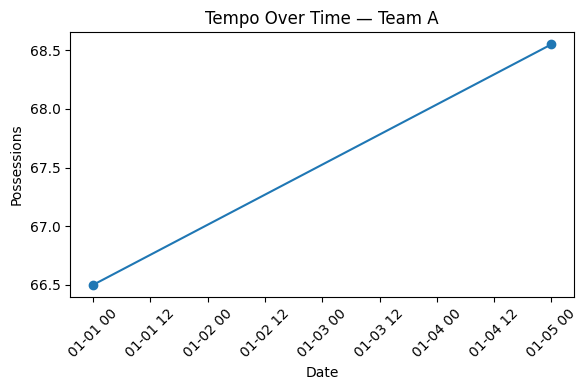

In [10]:
import matplotlib.pyplot as plt

def plot_team_tempo(df, team_name):
    team_df = df[df["team"] == team_name].sort_values("date")
    plt.figure(figsize=(6, 4))
    plt.plot(team_df["date"], team_df["poss"], marker="o")
    plt.title(f"Tempo Over Time — {team_name}")
    plt.xlabel("Date")
    plt.ylabel("Possessions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# test
plot_team_tempo(df, "Team A")


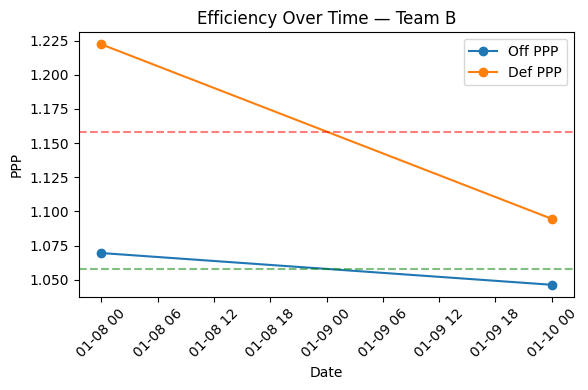

In [11]:
def plot_team_efficiency(df, team_name):
    team_df = df[df["team"] == team_name].sort_values("date")

    plt.figure(figsize=(6, 4))
    
    plt.plot(team_df["date"], team_df["off_ppp"], marker="o", label="Off PPP")
    plt.plot(team_df["date"], team_df["def_ppp"], marker="o", label="Def PPP")

    plt.axhline(team_df["off_ppp"].mean(), linestyle="--", color="green", alpha=0.5)
    plt.axhline(team_df["def_ppp"].mean(), linestyle="--", color="red", alpha=0.5)

    plt.title(f"Efficiency Over Time — {team_name}")
    plt.xlabel("Date")
    plt.ylabel("PPP")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# test
plot_team_efficiency(df, "Team B")


In [14]:
def league_summary(df):
    df = df.copy()
    
    # Add eff_margin if missing
    if "eff_margin" not in df.columns:
        df["eff_margin"] = df["off_ppp"] - df["def_ppp"]

    grouped = df.groupby("team").agg(
        avg_possessions=("poss", "mean"),
        off_ppp=("off_ppp", "mean"),
        def_ppp=("def_ppp", "mean"),
        eff_margin=("eff_margin", "mean"),
        games_played=("team", "count")
    ).reset_index()
    return grouped

league_df = league_summary(df)
league_df

,team,avg_possessions,off_ppp,def_ppp,eff_margin,games_played
0,Team A,67.5250,1.184570,1.088399,0.096170,2
1,Team B,63.7875,1.057898,1.158437,-0.100539,2
